# 05 — Base ML Model Training und Berichte

## Ziel
Dieses Notebook  führt die Modellierung der Spotify-Daten durch und erstellt Berichte zur Bewertung der Modellleistung.
Am Ende erzeugen wir:
- Verschiedene trainierte ML-Modelle zur Vorhersage, Clustering oder andere Aufgaben
- Einen Bericht zur Bewertung der Modellleistung

## Imports und Setup

In [12]:
import importlib


from utils.config.settings import (
ALLOW_LEAKY_FEATURES,
MAIN_ALBUM_STRATEGY,
RANDOM_SEED
)

from utils.reporting.reporting import save_json, save_joblib
from utils.models.success_pct import SuccessPctTrainer
from utils.models.success_residual import SuccessResidualTrainer
from utils.models.hit import HitTrainer
from utils.models.moods import MoodTrainer
from utils.models.ranker import RankerTrainer
from utils.models.artist_trajectory import ArtistTrajectoryTrainer
from utils.models.artist_clustering import ArtistClusteringRunner
from utils.models.track_similarity import TrackSimilarityRunner
from utils.data.training_data_loader import  load_all
from utils.data.datasets import  (
    build_success_pct_dataset,
    build_success_residual_dataset,
    build_hit_dataset,
    build_mood_dataset,
)
import utils.core.paths as paths


importlib.reload(paths)

SAMPLE_NAME = paths.load_sample_name()
PATHS = paths.make_paths(SAMPLE_NAME)
paths.ensure_dirs(PATHS)

RUN_META = paths.build_run_meta(
    PATHS,
    random_seed=RANDOM_SEED,
    allow_leaky_features=ALLOW_LEAKY_FEATURES,
    main_album_strategy=MAIN_ALBUM_STRATEGY,
)


## Globale Daten und Einstellungen

In [13]:
reports = {}

data = load_all(PATHS.input_targets_path)

ds_pct  = build_success_pct_dataset(data.X_track, data.track_df, data.y_success_pct)
ds_res  = build_success_residual_dataset(data.X_track, data.track_df, data.y_success_residual)
ds_hit  = build_hit_dataset(data.X_track, data.track_df, data.y_hit)
ds_mood = build_mood_dataset(data.X_track, data.track_df, data.Y_mood)

(ds_pct.X.shape, ds_res.X.shape, ds_hit.X.shape, ds_mood.X.shape)



((294454, 47), (294454, 47), (300000, 47), (300000, 35))

### Train: (A) Success Percentile within Cohort (Cohort-relative Success Scoring)

In diesem Schritt trainieren wir ein Modell, das die **relative Erfolgsposition** eines Tracks innerhalb seiner
Release-Kohorte vorhersagt. Statt absolute Popularity zu modellieren, nutzen wir ein kohorten-normalisiertes Target
(`success_pct_in_cohort`), das zeitliche Verzerrungen (z. B. Katalogwachstum, Popularity-Drift) reduziert.

**Warum?**
- Vergleiche über Zeiträume hinweg werden fairer (weniger Zeit-Bias).
- Liefert ein robustes „Success-Scoring“, das für Discovery/Ranking und als Input für Recommender geeignet ist.
- Ergänzt Learning-to-Rank: Neben Ranking kann auch ein stabiler **Score** gelernt werden.

**Wie?**
- Target: `success_pct_in_cohort = rank_pct(popularity within cohort) * 100`
- Split: zeitbasiert nach `cohort_ym` (Train/Val/Test) → verhindert Leakage.
- Modell: Gradient Boosting (XGBoost) für tabellarische Features.


In [14]:
pct_model, pct_metrics = SuccessPctTrainer(RANDOM_SEED).fit_eval(ds_pct)
reports["success_percentile_within_cohort"] = pct_metrics

### Train: (B) Success Residual within Cohort (Overperformance Regression)

In diesem Schritt trainieren wir ein Regressionsmodell für **Overperformance**:
Statt absolute Popularity zu schätzen, sagt das Modell vorher, ob ein Track **über oder unter**
dem Durchschnitt seiner Release-Kohorte performt.

**Warum?**
- robuster gegenüber Zeitdrift und Popularity-Inflation
- identifiziert „Hidden Gems“ und Tracks, die stärker performen als ihr Umfeld erwarten lässt
- eignet sich gut als Scoring-Signal für Discovery/Curations

**Wie?**
- Target: `success_residual_in_cohort = popularity - mean(popularity within cohort)`
- Split: zeitbasiert nach `cohort_ym` (Train/Val/Test), um Leakage zu vermeiden
- Modell: Gradient Boosting (XGBoost) für tabellarische Features


In [15]:
res_model, res_metrics = SuccessResidualTrainer(RANDOM_SEED).fit_eval(ds_res)
reports["success_residual_within_cohort"] = res_metrics

### Train: Artist Trajectory Model (Growth + Breakout)

In diesem Schritt trainieren wir ein **zeitbewusstes Artist-Trajectory-Modell**, das zukünftige Entwicklung von Künstlern prognostiziert.
Das Ziel ist nicht „wer ist jetzt populär“, sondern **wer wächst als Nächstes**.

**Targets**
- **Growth (Regression):** erwartetes Wachstum über einen festen Horizont
  $$ (\Delta = \text{future\_mean\_pop} - \text{past\_mean\_pop}) $$
- **Breakout (Klassifikation):** 1, wenn der Artist im **Top-X%** der Wachstumswerte liegt (innerhalb des Jahres)

**Warum?**
- Robust gegen Zeit-Bias (Katalog wächst, Popularity driftet).
- Nützlich für „Artists to Watch“, Playlist-Curation und A&R/Trend-Analysen.

**Wie?**
- Wir nutzen eine **Artist-Month Panel-Tabelle** mit Rolling-Window-Features (nur Vergangenheit).
- Split erfolgt **zeitlich** (Train/Val/Test nach Monaten), um Leakage zu vermeiden.
- Modelle: Gradient-Boosting (z. B. XGBoost) für Regression und Klassifikation.



In [16]:
artist_models, growth_m, breakout_m = ArtistTrajectoryTrainer(RANDOM_SEED).fit_eval(data.artist_panel)
reports["artist_trajectory_growth"] = growth_m
reports["artist_trajectory_breakout"] = breakout_m

### Train: Top-K Recommender (Learning-to-Rank)

In diesem Schritt trainieren wir ein **Top-K Recommender-Modell** auf Basis von
**Learning-to-Rank**, um Tracks **relativ zueinander** zu bewerten statt absolute
Vorhersagen zu treffen.

#### Motivation
Klassische Regressionsmodelle (z. B. Popularity-Vorhersage) sind für
Empfehlungssysteme oft ungeeignet, da:
- Popularity stark skaliert und zeitabhängig ist,
- absolute Scores weniger relevant sind als **relative Reihenfolgen**,
- Nutzer- und Playlist-Szenarien fast immer ein **Top-K Ranking** benötigen.

Ein Ranking-Modell beantwortet stattdessen die Frage:
> *Welche Tracks sollten innerhalb eines gegebenen Kontexts weiter oben stehen?*

#### Trainingsziel
Als Zielvariable verwenden wir ein **kohortenrelatives Erfolgsmaß**, z. B.:

- **Success Percentile within Cohort** *(A)*
  → ordnet Tracks nach ihrer relativen Performance innerhalb desselben Release-Zeitfensters

oder alternativ:
- **Success Residual within Cohort** *(B)*
  → belohnt Tracks, die **besser als der Durchschnitt ihrer Kohorte** performen

Diese Targets sind robust gegenüber:
- Release-Zeit-Bias
- Katalogwachstum
- Popularity-Inflation über Jahre hinweg

#### Modelltyp
Wir verwenden ein **Gradient-Boosted Learning-to-Rank Modell** (z. B. `XGBRanker`):

- Eingabe: Track-Features (`X_track`)
- Gruppierung: **Cohorts** (z. B. Release-Monat oder -Jahr)
- Ausgabe: ein **Ranking-Score** pro Track

Das Modell lernt explizit, **korrekte Paar- und Gruppenordnungen** zu optimieren,
statt einzelne Zielwerte zu approximieren.

#### Ergebnis
Das trainierte Modell ermöglicht:
- **Top-K Track Empfehlungen** pro Kohorte
- „Trending-Track“ Listen ohne Nutzerhistorie
- robuste Rankings für Cold-Start-Szenarien

Die Modellqualität evaluieren wir mit ranking-spezifischen Metriken wie:
- NDCG@K
- Hit-Rate@K
- Mean Reciprocal Rank (MRR)

Dieses Recommender-Modell bildet die Grundlage für alle
**ranking-basierten Empfehlungsszenarien** im Projekt.


In [17]:
rank_model, rank_metrics = RankerTrainer(RANDOM_SEED).fit_eval(ds_pct)
reports["ranker"] = rank_metrics


## Train: Hit Prediction (Binary Classification, XGBoost)

Ziel: Vorhersage, ob ein Track ein **Hit** ist (`0/1`).

### Warum XGBoost?
- Lernt komplexe Regeln (nichtlinear)
- Oft deutlich bessere PR-AUC/F1 bei “Hit”-ähnlichen Problemen

### Zwei wichtige Tricks
1. **Class Imbalance**: Wir setzen `scale_pos_weight`.
2. **Threshold-Tuning**: Wir wählen den Threshold, der den F1-Score maximiert.



In [18]:
hit_model, hit_metrics, hit_thr = HitTrainer(RANDOM_SEED).fit_eval(ds_hit)
reports["hit_prediction"] = hit_metrics


### Train : Künstler-Clustering (Unsupervised)

Ziel: Künstler in **Segmente/Cluster** einteilen (z.B. für Exploration, Empfehlungen, Marketing-Personas oder später als Feature).

**Idee:** Kein Graph-Community-Detection (Louvain/Leiden), sondern **Feature-basiertes Clustering**.

**Pipeline (kurz):**
1) Artist-Features auswählen (Follower/Popularity/Katalog + Audio-Feature-Mittelwerte, optional Genre-Multi-Hot)
2) Fehlwerte imputieren (Median)
3) Skalieren (wichtig, weil Distanz-basiert)
4) PCA (stabiler/schneller für KMeans)
5) KMeans → `artist_df["cluster"]`
Optional: t-SNE nur als visuelle Diagnose auf einem Sample

**Outputs:**
- `artist_df["cluster"]`
- gespeicherte Artefakte: Preprocessing + PCA + KMeans (`artist_clustering.joblib`)
- Dataset mit Clustern als Parquet


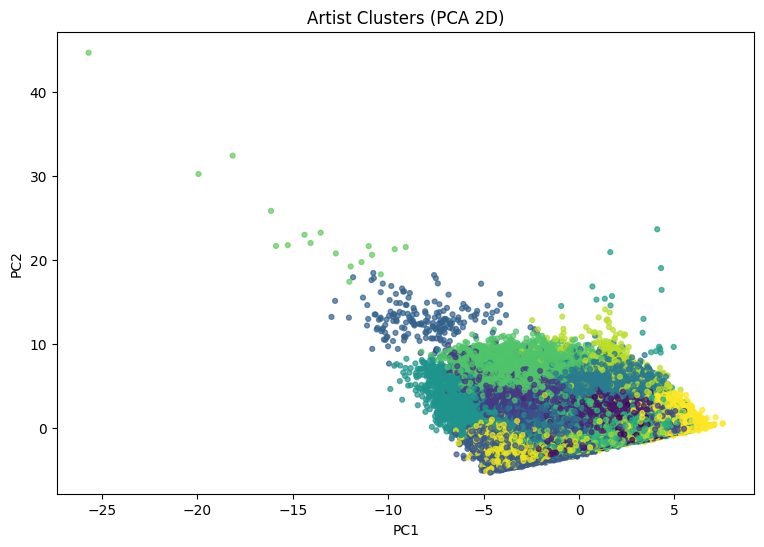

In [19]:
cluster_runner = ArtistClusteringRunner(k=30, seed=RANDOM_SEED)
models, artifact, extra = cluster_runner.run(data.artist_df)
cluster_runner.plot_pca2(extra["X_used"], extra["labels"])
reports["artist_clustering"] = artifact

### Train: Track-to-Track Similarity (Unsupervised Embeddings)

In diesem Schritt trainieren wir ein **unüberwachtes Similarity-Modell**, um „**Songs wie dieser**“-Empfehlungen ohne Nutzerhistorie zu ermöglichen.
Dazu lernen wir pro Track einen kompakten **Embedding-Vektor** ausschließlich aus den **Audio-Features** (z. B. Energy, Danceability, Valence).

**Warum?**
- Kein User-Log notwendig → funktioniert auch im **Cold-Start**.
- Embeddings liefern eine **kontinuierliche „Vibe“-Repräsentation** (statt harter Genre-Labels).
- Ähnlichkeitssuche wird effizient: Top-K über **Cosine Similarity** im Embedding-Space.

**Wie?**
- Wir skalieren Audio-Features und trainieren einen **Autoencoder**:
  - Encoder komprimiert Features → Embedding
  - Decoder rekonstruiert die Original-Features
- Nach dem Training erzeugen wir Embeddings für alle Tracks und berechnen Ähnlichkeit per **Cosine Similarity**.
- Ergebnis: `get_similar_tracks(track_id, k)` liefert die Top-K ähnlichsten Tracks.


In [20]:
runner = TrackSimilarityRunner()
sim_models, sim_artifact = runner.fit(data.track_df)
reports["track_similarity"] = sim_artifact

# pick an example key (use your old key or from artifact)
example_key = sim_artifact["example_key"]

similar = runner.get_similar(
    track_key=example_key,
    track_index=data.track_df.index,
    embeddings=sim_models["embeddings"],
    top_k=10,
)
similar



[(221831, 0.9990036466539194),
 (21887, 0.9953587741937878),
 (229448, 0.9951814512234438),
 (101942, 0.9950964092370893),
 (289638, 0.9940824352042811),
 (268856, 0.9934581722447189),
 (286033, 0.9930600279662987),
 (64696, 0.9924939759721448),
 (175510, 0.9922953768283413),
 (275475, 0.9921373182503358)]


## Train: Mood Tags (Multi-Label)

Ziel: Mehrere Mood-Tags pro Track (z.B. happy, energetic, calm).

### Modellwahl (skalierbar)
Wir nutzen **One-vs-Rest** mit einem schnellen linearen Modell (SGDClassifier),
weil Multi-Label bedeutet:
- pro Label ein eigener Klassifikator
- sehr gut skalierbar auf große, sparse Feature-Matrizen



In [21]:
mood_model, mood_metrics, mood_thresholds = MoodTrainer(RANDOM_SEED).fit_eval(ds_mood)
reports["mood_multilabel"] = mood_metrics

## Reports schreiben (JSON)

In diesem Schritt speichern wir die wichtigsten Ergebnisse aus Notebook 3 als **maschinenlesbare JSON-Reports**.

### Warum JSON-Reports?
Reine Notebook-Ausgaben sind nicht reproduzierbar.
JSON ermöglicht:

- Vergleich von Experimenten (Baseline vs. Tuning)
- Nachverfolgung von Verbesserungen über Zeit
- Nutzung in Dashboards oder CI-Pipelines
- Nachvollziehbarkeit für Notebook 4

### Was wird gespeichert?
- **Modell-Metriken** (Regression, Klassifikation, Mood, Clustering)
- **Dataset-Größen** (Tracks, Alben, Artists, Feature-Matrizen)

### Speicherort
Die Reports werden im Ordner **`reports/`** abgelegt
(z. B. `metrics_report.json`) und dienen als **zentrale Referenz** für diesen Run.


In [22]:
save_joblib({"model": pct_model}, PATHS.models_dir / "model_success_pct.joblib")
save_joblib({"model": res_model}, PATHS.models_dir / "xgb_success_residual.joblib")
save_joblib({"model": hit_model, "threshold": hit_thr}, PATHS.models_dir / "hit_model_xgb.joblib")
save_joblib({"model": mood_model, "thresholds": mood_thresholds}, PATHS.models_dir / "mood_ovr_sgd.joblib")
save_joblib({"model": rank_model}, PATHS.models_dir / "ranker_xgb.joblib")

if artist_models is not None:
    save_joblib(artist_models, PATHS.models_dir / "artist_trajectory_models.joblib")

save_joblib(cluster_runner, PATHS.models_dir / "artist_clustering.joblib")
save_joblib(sim_models, PATHS.models_dir / "track_similarity.joblib")

reports["dataset_shapes"] = {
    "track_df": list(data.track_df.shape),
    "album_df": list(data.album_df.shape),
    "artist_df": list(data.artist_df.shape),
    "X_track": list(data.X_track.shape),
    "artist_panel": list(data.artist_panel.shape) if data.artist_panel is not None else None,
}
reports["run_config"] = {
    "random_seed": RANDOM_SEED,
    "allow_leaky_features": ALLOW_LEAKY_FEATURES,
}

save_json(reports, PATHS.reports_dir / "metrics_report.json")
reports



{'success_percentile_within_cohort': {'MAE': 21.59246960098823,
  'RMSE': 25.805375180680997,
  'R2': 0.19591045544685093,
  'n': 2955,
  'n_train': 288522,
  'n_val': 2977,
  'n_test': 2955,
  'label_range_expected': [0, 100]},
 'success_residual_within_cohort': {'train': {'MAE': 5.807528495788574,
   'RMSE': 8.83053107767418,
   'R2': 0.22146880626678467,
   'n': 288522},
  'val': {'MAE': 10.554997444152832,
   'RMSE': 13.73842286055108,
   'R2': 0.2912479639053345,
   'n': 2977},
  'test': {'MAE': 11.997377395629883,
   'RMSE': 15.03981735118586,
   'R2': 0.20653295516967773,
   'n': 2955}},
 'artist_trajectory_growth': {'MAE_log': 0.04578463165887853,
  'RMSE_log': 0.13904399813481608,
  'R2_log': 0.9849392775269714,
  'n_test': 3575},
 'artist_trajectory_breakout': {'ROC_AUC': 0.9889004097648881,
  'PR_AUC': 0.9096537373415785,
  'breakout_rate_test': 0.10125874125874126,
  'n_test': 3575},
 'ranker': {'mean_ndcg@k': 0.7428412982076612, 'k': 10},
 'hit_prediction': {'roc_auc': 0.8